## iş problemi

Online ayakkabı mağazası olan FLO müşterilerini
segmentlere ayırıp bu segmentlere göre pazarlama
stratejileri belirlemek istiyor. Buna yönelik olarak
müşterilerin davranışları tanımlanacak ve bu
davranışlardaki öbeklenmelere göre gruplar oluşturulacak

## veriseti hikayesi

Veri seti Flo’dan son alışverişlerini 2020 - 2021 yıllarında OmniChannel (hem online hem offline alışveriş yapan)
olarak yapan müşterilerin geçmiş alışveriş davranışlarından elde edilen bilgilerden oluşmaktadır.



In [159]:
import numpy as np
import pandas as pd
import datetime as dt
import squarify
import matplotlib.pyplot as plt
import seaborn as sns
import random
import collections
import string
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_period_transactions
from lifetimes import GammaGammaFitter

sns.set_palette("viridis")


In [2]:
data = pd.read_csv("flo_data_20k.csv")
df = data.copy()

In [3]:
def ExploreDataset(df):
    print(f"""
    
    -- Dataset Columns --
    
    {df.columns.tolist()}
    
    -- Dataset Shape --
    
    {df.shape}
    
    -- Is There Any NaN Values? --
    
    {df.isna().values.any()}
    
    -- Dataset Columns' Dtypes --
    
    {df.dtypes}
    
    -- Dataset First 5 Observation --
    
    """)
    
    return df.head()

In [4]:
ExploreDataset(df)


    
    -- Dataset Columns --
    
    ['master_id', 'order_channel', 'last_order_channel', 'first_order_date', 'last_order_date', 'last_order_date_online', 'last_order_date_offline', 'order_num_total_ever_online', 'order_num_total_ever_offline', 'customer_value_total_ever_offline', 'customer_value_total_ever_online', 'interested_in_categories_12']
    
    -- Dataset Shape --
    
    (19945, 12)
    
    -- Is There Any NaN Values? --
    
    False
    
    -- Dataset Columns' Dtypes --
    
    master_id                             object
order_channel                         object
last_order_channel                    object
first_order_date                      object
last_order_date                       object
last_order_date_online                object
last_order_date_offline               object
order_num_total_ever_online          float64
order_num_total_ever_offline         float64
customer_value_total_ever_offline    float64
customer_value_total_ever_online     float64

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0,1.0,139.99,799.38,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0,2.0,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0,2.0,189.97,395.35,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0,1.0,39.99,81.98,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0,1.0,49.99,159.99,[AKTIFSPOR]


# data PREprocessing


In [5]:
# type conversion
df['first_order_date'] = pd.to_datetime(df['first_order_date'])
df['last_order_date'] = pd.to_datetime(df['last_order_date'])
df['last_order_date_online'] = pd.to_datetime(df['last_order_date_online'])
df['last_order_date_offline'] = pd.to_datetime(df['last_order_date_offline'])

In [6]:
# new features

df["Total_Order"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]
df["Total_Payment"] = df["customer_value_total_ever_offline"] + df["customer_value_total_ever_online"]

# HighlightActions

In [7]:
def HighlightActions(df,highlight_level=5):
    order_df = df[["master_id","Total_Order"]].sort_values(by="Total_Order",ascending=False)[:highlight_level]
    payment_df = df[["master_id","Total_Payment"]].sort_values(by="Total_Payment",ascending=False)[:highlight_level]

    result = {}
    result["Highlight_Order"] = order_df.values.tolist()
    result["Highlight_Payment"] = payment_df.values.tolist()

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle('Initial Pokemon - 1st Generation')


    sns.barplot(ax=axes[0], x=np.arange(1,highlight_level+1), y=order_df["Total_Order"].values)
    axes[0].set_title('Highlight: Order')

    sns.barplot(ax=axes[1], x=np.arange(1,highlight_level+1), y=payment_df["Total_Payment"].values)
    axes[1].set_title('Highlight: Payment')

    
    return result

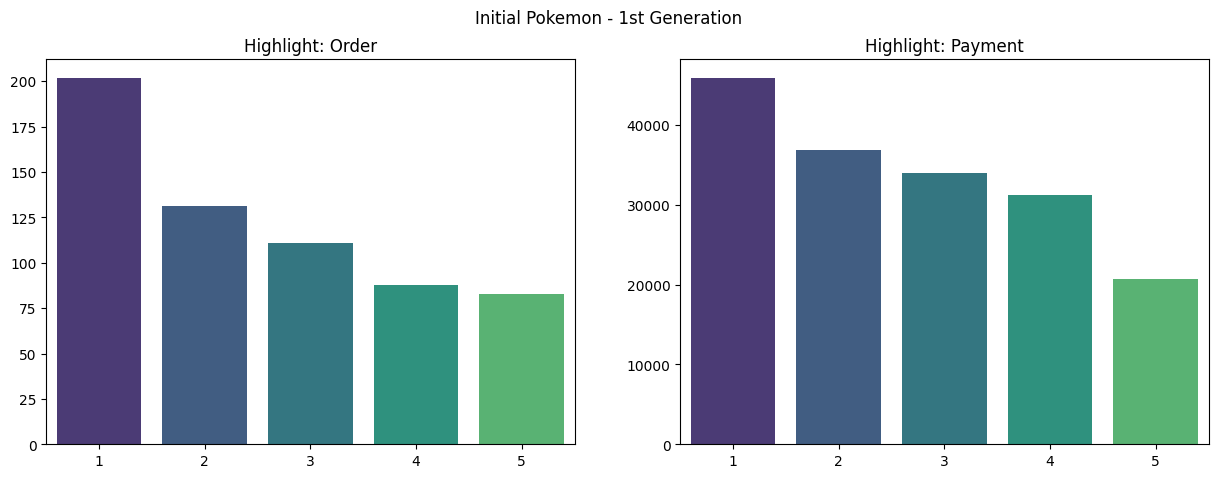

In [12]:
HighlightActions_result = HighlightActions(df)

In [116]:
HighlightActions_result

{'Highlight_Order': [['5d1c466a-9cfd-11e9-9897-000d3a38a36f', 202.0],
  ['cba59206-9dd1-11e9-9897-000d3a38a36f', 131.0],
  ['a57f4302-b1a8-11e9-89fa-000d3a38a36f', 111.0],
  ['fdbe8304-a7ab-11e9-a2fc-000d3a38a36f', 88.0],
  ['329968c6-a0e2-11e9-a2fc-000d3a38a36f', 83.0]],
 'Highlight_Payment': [['5d1c466a-9cfd-11e9-9897-000d3a38a36f', 45905.1],
  ['d5ef8058-a5c6-11e9-a2fc-000d3a38a36f', 36818.29],
  ['73fd19aa-9e37-11e9-9897-000d3a38a36f', 33918.1],
  ['7137a5c0-7aad-11ea-8f20-000d3a38a36f', 31227.41],
  ['47a642fe-975b-11eb-8c2a-000d3a38a36f', 20706.34]]}

In [20]:
# RFM

In [13]:
def RFM(df,return_segment=None):
    analyze_date = df.last_order_date.max() + dt.timedelta(days=2)
    rfm_df = df.groupby("master_id").agg({"last_order_date": lambda date: (analyze_date - date.max()).days,
                                   "Total_Order" : lambda Total_Order:Total_Order,
                                   "Total_Payment": lambda Total_Payment: Total_Payment.sum()})
    rfm_df.columns = ["recency","frequency","monetary"]
    rfm_df = rfm_df[rfm_df.monetary > 0]
    rfm_df["recency_score"] = pd.qcut(rfm_df['recency'],5,labels=[5,4,3,2,1])
    rfm_df["monetary_score"] = pd.qcut(rfm_df['monetary'],5,labels=[1,2,3,4,5])
    rfm_df["frequency_score"] = pd.qcut(rfm_df['frequency'].rank(method='first'),5,labels=[1,2,3,4,5])
    rfm_df["RF_SCORE"] = rfm_df.recency_score.astype(str) + rfm_df.frequency_score.astype(str)


    seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'}
    rfm_df["segment"] = rfm_df.RF_SCORE.replace(seg_map,regex=True)
    
    if return_segment != None:
        segment = {}
        for i in return_segment:
            segment[i+"_id"] = rfm_df[rfm_df.segment == i].index.tolist()
            return rfm_df,segment
    
    else:
        return rfm_df

In [14]:
rfm_df,attention_users = RFM(df,return_segment=["champions","need_attention"])

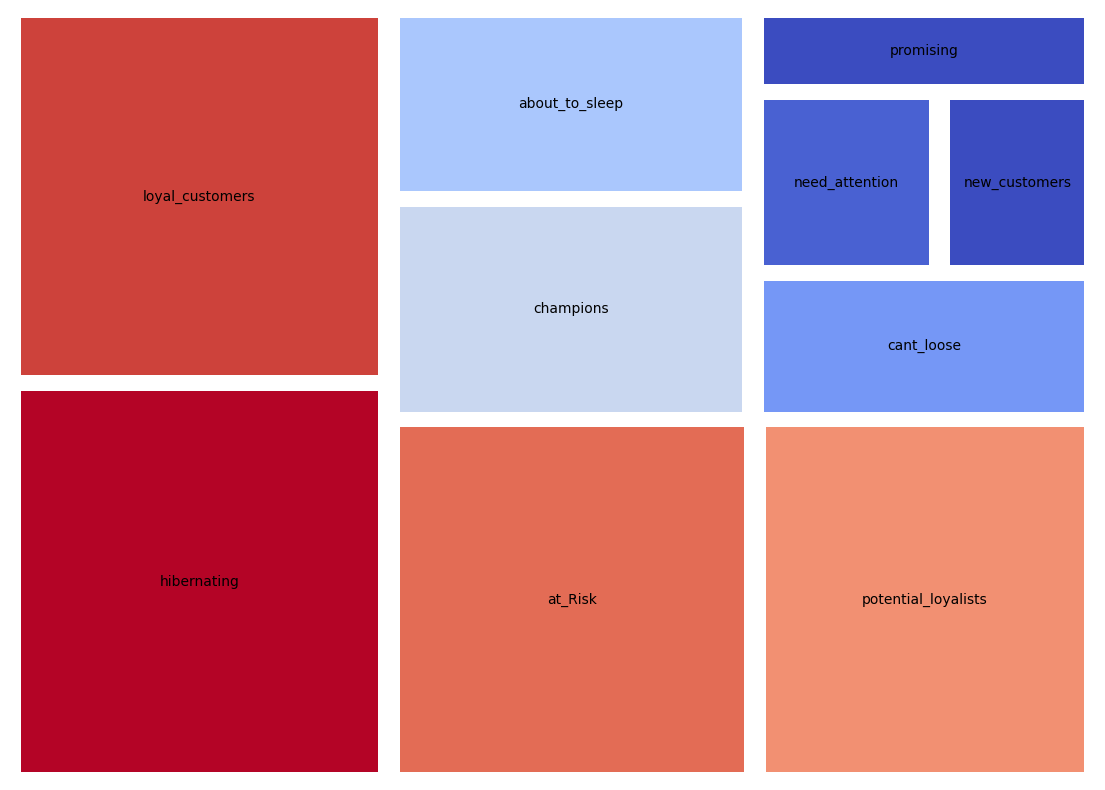

In [150]:
import matplotlib
rfm_df.reset_index(inplace=True)
sq1 = rfm_df.groupby("segment")["master_id"].nunique().sort_values(ascending=False).reset_index()
cmap = matplotlib.cm.coolwarm
mini = min(sq1["master_id"])
maxi = max(sq1["master_id"])
norm = matplotlib.colors.Normalize(vmin=mini,vmax=maxi)
colors = [cmap(norm(value)) for value in sq1["master_id"]]
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14,10)
squarify.plot(sizes=sq1["master_id"],
             label = sq1.segment,
             alpha=1,pad=True,
             color=colors)

plt.axis("off")
plt.show()

# cltv
## BG/NBD + Gamma-Gamma


In [186]:
def CLTV(df,
         cltv_time=6,
         cltv_discount_rate=0.01,
         weekly_best_purchaser=True):
    
    
    analyze_date = df.last_order_date.max() + dt.timedelta(days=2)
    
    cltv_df = pd.DataFrame({"customer_id": df["master_id"],
             "recency_weekly": ((df["last_order_date"] - df["first_order_date"]).dt.days)/7,
             "t_weekly": ((analyze_date - df["first_order_date"]).astype('timedelta64[D]'))/7,
             "frequency": df["Total_Order"],
             "monetary_cltv_avg": df["Total_Payment"] / df["Total_Order"]})
    
    bgf = BetaGeoFitter(penalizer_coef=0.001)
    bgf.fit(cltv_df['frequency'],cltv_df['recency_weekly'],cltv_df['t_weekly'])
    cltv_df["exp_sales_3_month"] = bgf.predict(4 * 3,cltv_df['frequency'],cltv_df['recency_weekly'],cltv_df['t_weekly'])
    cltv_df["exp_sales_6_month"] = bgf.predict(4 * 6,cltv_df['frequency'],cltv_df['recency_weekly'],cltv_df['t_weekly'])
    
    plot_period_transactions(bgf)
    plt.show()
    
    ggf = GammaGammaFitter(penalizer_coef=0.01)
    ggf.fit(cltv_df['frequency'], cltv_df['monetary_cltv_avg'])
    cltv_df['exp_average_value'] = ggf.conditional_expected_average_profit(cltv_df['frequency'], cltv_df['monetary_cltv_avg'])
    
    cltv_df["CLTV"] = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency_weekly'],
                                   cltv_df['t_weekly'],
                                   cltv_df['monetary_cltv_avg'],
                                   time=cltv_time, 
                                   freq="W", 
                                   discount_rate=cltv_discount_rate) 

    cltv_df["segment"] = pd.qcut(cltv_df["CLTV"], 4, labels=["D", "C", "B", "A"])
    
    if weekly_best_purchaser:
        bgf.conditional_expected_number_of_purchases_up_to_time(1,cltv_df['frequency'],cltv_df['recency_weekly'],cltv_df['t_weekly']).sort_values(ascending=False).head(10)
        best_purchaser = bgf.predict(1,cltv_df['frequency'],cltv_df['recency_weekly'],cltv_df['t_weekly']).sort_values(ascending=False).head(10)    
        return cltv_df, best_purchaser
    
    else:
        return cltv_df

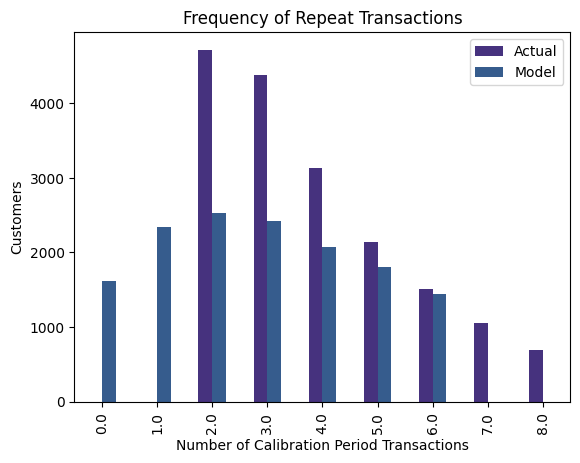

In [192]:
cltv_df,weekly_best_purchaser = CLTV(df,weekly_best_purchaser=True)

In [193]:
cltv_df.iloc[weekly_best_purchaser.index]

,customer_id,recency_weekly,t_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value,CLTV,segment
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.714286,67.285714,70.0,263.479571,6.349962,12.699905,264.019264,3518.063500,A
6322,329968c6-a0e2-11e9-a2fc-000d3a38a36f,111.571429,119.714286,83.0,51.088675,5.424987,10.849963,51.216562,583.050651,A
11150,5d1c466a-9cfd-11e9-9897-000d3a38a36f,394.000000,398.571429,202.0,227.252970,5.244657,10.489310,227.416863,2502.863834,A
9347,44d032ee-a0d4-11e9-a2fc-000d3a38a36f,104.428571,120.142857,77.0,67.325325,5.035152,10.070292,67.490155,713.099488,A
14402,03f502d4-a559-11e9-a2fc-000d3a38a36f,104.714286,118.714286,61.0,45.220820,4.065874,8.131740,45.382623,387.204758,A
4315,d5ef8058-a5c6-11e9-a2fc-000d3a38a36f,133.142857,147.142857,68.0,541.445441,3.921505,7.843002,542.523810,4464.458196,A
8043,4a51668a-a155-11e9-a2fc-000d3a38a36f,87.142857,98.857143,51.0,86.154118,3.835726,7.671443,86.450435,695.843950,A
15611,4a7e875e-e6ce-11ea-8f44-000d3a38a36f,39.714286,40.000000,29.0,165.297586,3.493173,6.986332,166.169593,1218.059072,A
18067,695889b4-d6ed-11e9-93bc-000d3a38a36f,91.857143,103.857143,47.0,175.458085,3.452815,6.905622,176.022893,1275.379914,A
8328,1902bf80-0035-11eb-8341-000d3a38a36f,28.857143,33.285714,25.0,97.439600,3.259070,6.518127,98.103588,670.927000,A


In [182]:
cltv_df.groupby("segment")[["exp_sales_3_month","exp_sales_6_month","exp_average_value","CLTV"]].agg({"mean","sum"}).T

segment                             D              C              B  \
exp_sales_3_month mean       0.406343       0.525797       0.604984   
                  sum     2026.432952    2621.622128    3016.450072   
exp_sales_6_month mean       0.812684       1.051591       1.209965   
                  sum     4052.856765    5243.231784    6032.885762   
exp_average_value mean      99.025388     132.583965     167.830655   
                  sum   493839.610693  661063.650415  836803.644469   
CLTV              mean      80.006126     138.489449     200.411668   
                  sum   398990.552339  690508.392017  999252.578979   

segment                            A  
exp_sales_3_month mean  7.911037e-01  
                  sum   3.944443e+03  
exp_sales_6_month mean  1.582204e+00  
                  sum   7.888867e+03  
exp_average_value mean  2.387558e+02  
                  sum   1.190436e+06  
CLTV              mean  3.725150e+02  
                  sum   1.857360e+06

In [183]:
cltv_df

,customer_id,recency_cltv_weekly,t_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value,CLTV,segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.000000,30.571429,5.0,187.874000,0.995983,1.991959,193.632763,404.694063,A
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.857143,224.857143,21.0,95.883333,0.990909,1.981816,96.665051,201.001990,B
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.285714,78.857143,5.0,117.064000,0.676272,1.352541,120.967652,171.667110,B
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.571429,20.857143,2.0,60.985000,0.711125,1.422243,67.320130,100.458381,D
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.142857,95.428571,2.0,104.990000,0.393603,0.787204,114.325181,94.427104,D
...,...,...,...,...,...,...,...,...,...,...
19940,727e2b6e-ddd4-11e9-a848-000d3a38a36f,41.142857,88.428571,3.0,133.986667,0.485769,0.971536,141.360453,144.096736,C
19941,25cd53d4-61bf-11ea-8dd8-000d3a38a36f,42.285714,65.285714,2.0,195.235000,0.480279,0.960554,210.722654,212.373662,B
19942,8aea4c2a-d6fc-11e9-93bc-000d3a38a36f,88.714286,89.857143,3.0,210.980000,0.481534,0.963066,221.775389,224.097454,B
19943,e50bb46c-ff30-11e9-a5e8-000d3a38a36f,98.428571,113.857143,6.0,168.295000,0.613353,1.226704,172.647515,222.212022,B


<br> <br>

## şirket senaryoları


# 1

Şirket, az kullanılan şipariş kanallarına özel bir kampanya düzenlemek istiyor. En az kullanılan 2 şipariş kanalına özel kampanya kodu tanımlanmalı.

In [153]:
campaign_channels = df.order_channel.value_counts().sort_values()[:2].index.to_list()
for i in campaign_channels:
    print("CAMPAIGN CODE for",i,"=",i.replace(" ","")+"_"+"".join(random.choice(string.ascii_letters) for i in range(5)))

CAMPAIGN CODE for Desktop = Desktop_VIyWd
CAMPAIGN CODE for Ios App = IosApp_xrNfE


# 2

Şirket, belirli kategorilerde ve belirli segmentlerde yer alan müşterilerine özel kampanya kodu üretmek istiyor. Otomatize edilmiş bir kampanya oluşturma fonksiyonu isteniyor.

In [194]:
def CampaignCreator(target_segment,
                    target_category,
                    campaign_code=bool,
                    only_customerid=bool):
    if campaign_code:
        print("CAMPAIGN CODE for",target_segment,target_category,"=",target_category.replace(" ","")+"_"+"".join(random.choice(string.ascii_letters) for i in range(5)))

    merged_df = pd.merge(rfm_df[rfm_df.segment==target_segment]["segment"],(df[df.interested_in_categories_12.str.contains(target_category)]),on="master_id")
    
    if only_customerid:
        return merged_df["master_id"]
    else:
        return merged_df

In [195]:
CampaignCreator(target_category="KADIN",
                target_segment="champions",
                campaign_code=True,
                only_customerid=True)

CAMPAIGN CODE for champions KADIN = KADIN_tbSDd


KeyError: 'master_id'

# 3

Şirket, hangi kategorilere ilgi olduğunu ve en çok hangi kategorilerin kazandırdığını öğrenmek istiyor.

In [88]:
def CategoriesFunction(x):
    x=x.replace("[","")
    x=x.replace("]","")
    x=x.split(", ")
    return x

In [122]:
categories_list = df.interested_in_categories_12.apply(CategoriesFunction)

In [123]:
product_categories = {}
for i in categories_list:
    for j in i:
        if j not in product_categories.keys():
            product_categories[j] = 1
        else:
            product_categories[j] +=1

In [125]:
product_categories["Unkown"] = product_categories.pop("")
product_categories = collections.OrderedDict(sorted(product_categories.items(), key=lambda kv: kv[1]))

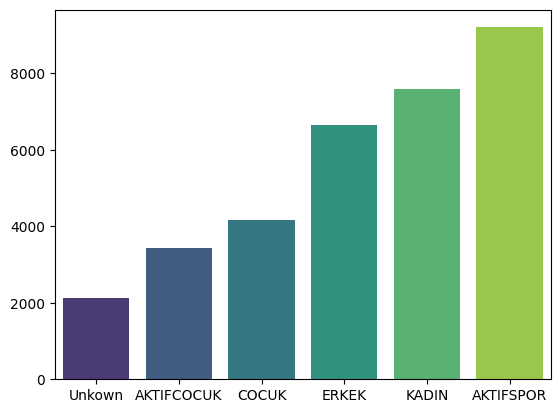

In [129]:
sns.barplot(x=list(product_categories.keys()),y=list(product_categories.values()));

In [145]:
df.groupby("interested_in_categories_12")["Total_Payment"].sum().sort_values(ascending=False)[:5]

interested_in_categories_12
[AKTIFSPOR]           2373965.87
[KADIN]               1139066.02
[]                    1136553.55
[KADIN, AKTIFSPOR]    1132049.56
[ERKEK]               1106934.44
Name: Total_Payment, dtype: float64

# 4

Şirket, online ve offline alışverilerden ürün başına ortalama ne kadar kazandığının hesaplanmasını istiyor.

In [137]:
print(f"""
Online: {(df["customer_value_total_ever_online"] / df["order_num_total_ever_online"]).mean()}
Offline: {(df["customer_value_total_ever_offline"] / df["order_num_total_ever_offline"]).mean()}
""")


Online: 165.9289216098459
Offline: 135.7509556651877

